Check Python version

In [268]:
!python --version

Python 3.10.14


Import libraries

In [269]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [270]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [271]:
train_df = pd.read_csv(file_name)

In [272]:
train_df.shape

(144, 2)

In [273]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [274]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [275]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [276]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [277]:
train_df[target_col] = train_df[target_col].astype(float)

In [278]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

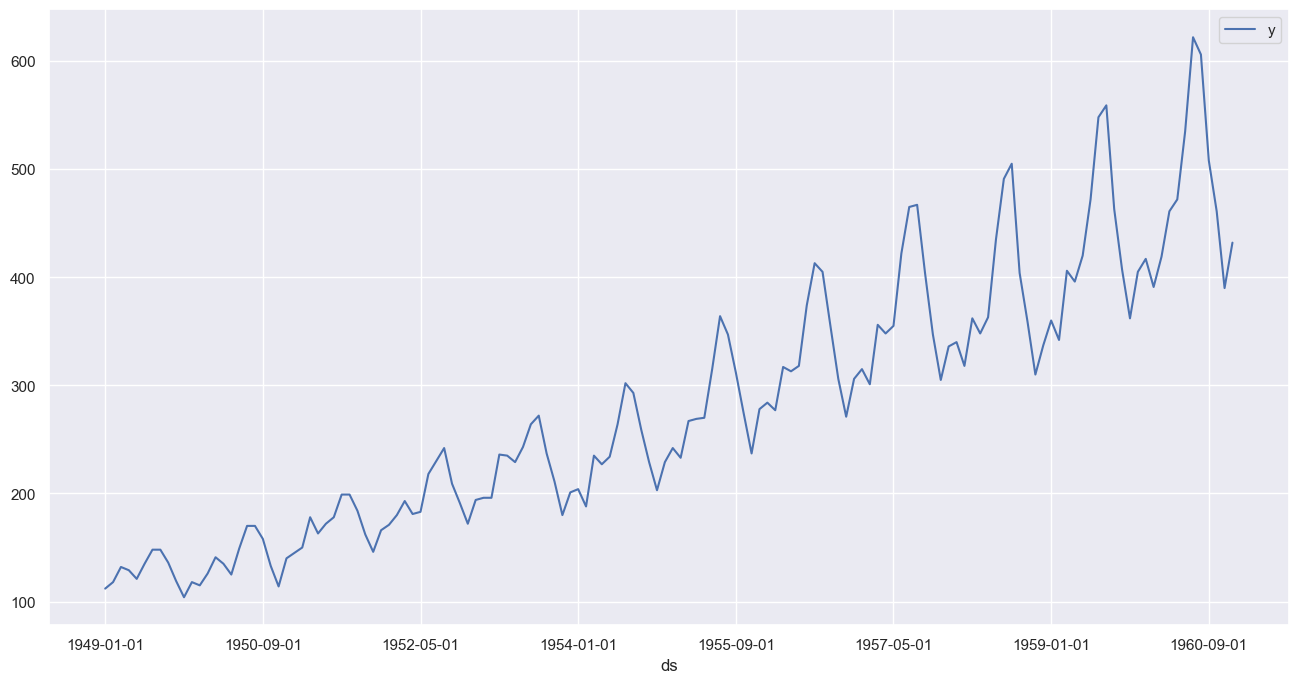

In [279]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [280]:
train_data = []

In [281]:
for value in train_df.values:
    train_data.append(list(value))

In [282]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [283]:
# Default model request
model_request = {
    'type': 'meta_wa',
    'scorers': ['smape', 'mase'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer'},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            {'type': 'darts_naive'},
            # {'type': 'darts_seasonalnaive'},
            # {'type': 'darts_autotheta'},
            # {'type': 'darts_autoarima'},
            # {'type': 'darts_autoets'},
        ],
    },
}

# # Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
# # np_external_model_request = None

# user_value = 0.9
# output_type = 'data'  # 'data', 'estimate'
# mauq_external_params = {
#     'data': train_df.values.tolist(),
#     'problem_type': 'regression',
#     'confidence_level': user_value,
#     'output_type': output_type

# }

# # Customized model request
# model_request = {
#     'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
#     'scorers': ['mase', 'smape'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             # {'type': 'darts_seasonalnaive'},
#             # {'type': 'darts_autotheta'},
#             # {'type': 'stats_autotheta'},
#             # {'type': 'darts_autoets'},
#             # {'type': 'stats_autoets'},
#             # {'type': 'darts_autoarima'},
#             # {'type': 'stats_autoarima'},
#             # {'type': 'darts_autoces'},
#             # {'type': 'darts_kalman'},
#             # {'type': 'darts_catboost'},            
#             # # {'type': 'darts_tbats'},
#             # # {'type': 'darts_linearregression'},
#             # {'type': 'darts_lightgbm',
#             #  'params': {
#             #      'lags': 12,
#             #      'output_chunk_length': 6,
#             #      'verbose': -1
#             # }}
#             # {'type': 'neuralprophet',
#             #  'external_params': np_external_model_request
#             # }  # Onboard NeuralProphet external service
#         ],
#         'mauq_params':[
#             mauq_external_params
#         ]
#     },
# }

This is for JSON model_request

In [284]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [285]:
# file_path = 'model_request.yaml'
# # For reading the model request from a yaml file
# with open(file_path, 'r') as file:
#     model_request = yaml.safe_load(file)

Train API JSON Payload

In [286]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

In [287]:
api_json['model']

{'type': 'meta_wa',
 'scorers': ['smape', 'mase'],
 'params': {'preprocessors': [{'type': 'dartsimputer'},
   {'type': 'minmaxscaler'}],
  'base_models': [{'type': 'darts_naive'}]}}

Build URL

In [288]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [296]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [297]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [298]:
# %%time
# print("Hello")
response = requests.post(url, json=api_json)
# print(response)
# print()

In [299]:
train_json_out = response.json()  # dict output
train_json_out
# response.json()

{'model': 'AgEBCDwbAAA4GwAAixoAABgAAACDGgAAZwMAAIAAZWxpk4xvlGxvjG2UBGFplHNyYZQojC50bZRNk3BveJRJjC5kbUlljBVvaQx0jIx5QygklIkDSv9DbpRkLi5ld22TdGQoZHOUX2V5k2FhYZRplE4CUk7/KEt0AJRoiGj/AJSUgMbEAwFqaNHOzDUynJmX19Q9O6ShnwgGb2xqqqcQDnd1ctvZQj89Eg94dt/c2kNBqqel5eJLSbKwrRYUfXp4uLUeHIWDgOnnUE5Li4ny71hWU726IyEe8/BZV8C+uyQii4iGxsQtKpORjvf1XlxZmZcA/WZkYsvIMS8sbGrT0To3NZ6bBAIA1NI7OKGfnQYDbH1xNXVSlHJtlHJmjF90c2hhlCgAAWhhAlJO/2IAjHUAUm9vZGV0QZRfXXJlfWFlY2JzZXaUD2eULmltlChfA2FycmGUlHJfeWGMYZMolGRhcmlueHSUcjxolGWMlGOUb5SUaH0ZlGhoAQJSlP90MWiyiQNLhraMlGVoYWmMSSkFOmgNaGgBQmsD6ICIICfAWWD4AJgxFa61TlXuho0mLcZeQ9zje4MbtLtUW/OMApuiOkLac3oTGrJLMMjPaG8IoKhASOB5Xfb9lp02ztVudQ6miyMrw8tj/AOcozvUSuLqgooiu8JaYvqTeBAXsLdQ6PCIjyjBpT5F3uV9Fh22vVbu02tzCxKrREvj64MckioyytFqAwqiqmJwbGllbpRSaHJ1dWlvcGJOaCMoS5Q1aHVuX2VylGhzlACUS4Ac+fnelxPDwxwKAPnDwyQTukgSEvABsaA2zCSGlySTk7EBuhNVqQXrb32Y2SmBl0jMzBJxVXqxurOtqRfeunHR0LGc8oxVnFXZXpXXeMrQ7uf9s4FI4AyIrfa7N/cgGSDK+5iP9xAYuWbufwGGrV6PAKhHrmZ7paMcyAfib8y2rHfYXjf+z5/WzB8A9yDW/zZodHaUYWiGb

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [257]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [258]:
model = train_json_out['model']

Forecast API JSON Payload

In [259]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [260]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [261]:
%%time
response = requests.post(url, json=api_json,verify=False)
print(response)
print()

<Response [200]>

CPU times: total: 0 ns
Wall time: 1min 49s


In [262]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1961-01-01', 432.0],
  ['1961-02-01', 432.0],
  ['1961-03-01', 432.0],
  ['1961-04-01', 432.0],
  ['1961-05-01', 432.0],
  ['1961-06-01', 432.0],
  ['1961-07-01', 432.0],
  ['1961-08-01', 432.0],
  ['1961-09-01', 432.0],
  ['1961-10-01', 432.0],
  ['1961-11-01', 432.0],
  ['1961-12-01', 432.0],
  ['1962-01-01', 432.0],
  ['1962-02-01', 432.0],
  ['1962-03-01', 432.0],
  ['1962-04-01', 432.0],
  ['1962-05-01', 432.0],
  ['1962-06-01', 432.0],
  ['1962-07-01', 432.0],
  ['1962-08-01', 432.0],
  ['1962-09-01', 432.0],
  ['1962-10-01', 432.0],
  ['1962-11-01', 432.0],
  ['1962-12-01', 432.0]]}

Combine forecast dates and output

In [263]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

## Mauq testing

In [264]:
model = train_json_out['model']
api_json = {
    'model': model,
    'data': dates
}
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)




In [265]:
%%time
response = requests.post(url, json=api_json,verify=False)
print(response)
print()


<Response [200]>

CPU times: total: 0 ns
Wall time: 2.06 s


In [266]:
with open('mauq_url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)
# URL to our MAUQ AWS service
protocol = url_dict['protocol']  # protocol not sybil_protocol
host = url_dict['host']
port = url_dict['port']
endpoint = 'quantify-uncertainty'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

FileNotFoundError: [Errno 2] No such file or directory: 'mauq_url.yaml'

In [ ]:
print(api_json)

{'model': 'AgEBCEYbAABAGwAA7RkAABgAAADjGQAAaAMAAIAAZWxpk4xvlGxvjG2UBGFplHNyYZQojC50bZRNk3BveJRJjC5kbUlljBVvaQx0jIx5QygklIkDSv9DbpRkLi5ld22TdGQoZHOUX2V5k2FhYZRplE4CUk7/KEt0AJRoiGj/AJSUgMbEAwFqaNHOzDUynJmX19Q9O6ShnwgGb2xqqqcQDnd1ctvZQj89Eg94dt/c2kNBqqel5eJLSbKwrRYUfXp4uLUeHIWDgOnnUE5Li4ny71hWU726IyEe8/BZV8C+uyQii4iGxsQtKpORjvf1XlxZmZcA/WZkYsvIMS8sbGrT0To3NZ6bBAIA1NI7OKGfnQYDbH1lYQUKjIaUjGFlXXNsF2RllAd4k4yMjCFyZpRO/0NaBGgAlGRkZXJhlChtlHRylHJsYWGUTWUpdF+MdGVlk4xkX3JlcnSTKGSMLnINcpSMaGFyZW5kaWVOcn01jJQGfW91bWgoq5SMkyMoS0+UTkqUlLxoiGgElH0GTnhieW4LboFpaEBOIyhLgMbEAwFqaNHOzDUynJmX19Q9O6ShnwgGb2xqqqcQDnd1ctvZQj89Eg94dt/c2kNBqqel5eJLSbKwrRYUfXp4uLUeHIWDgOnnUE5Li4ny71hWU726IyEe8/BZV8C+uyQii4iGxsQtKpORjvf1XlxZmZcA/WZkYsvIMS8sbGrT0To3NZ6bBAIA1NI7OKGfnQYDbH1haWJ0dJOUCmgDC3SGgWgglEuJYlJoBYxiVpSUjJQmlEuJAcHB0VGx4eEBYQDB4eFJsZGJqalxEUGh6TFJuVFJLS1BEZGx/fE1Re1pWaV1jVGJMTGp/wVPQZFTHfHV0ZH/XVVBfYPvBX0FpVU/kz0fVV8h5VONieNzyx2nmvKvJeclH9NZCa+X3oidX3sRuR1VCQDogCadV827AQ1H9e0xbRQ0nFXy7kyYijEcAK8livfplBFjZWVOY

In [ ]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

ConnectionError: HTTPConnectionPool(host='localhost', port=8001): Max retries exceeded with url: /quantify-uncertainty (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000026D123ECF70>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [ ]:
user_value = 0.9
output_type = 'data'  # 'data', 'estimate'
api_json = {
    'data': forecast_df['y'].values.tolist(),
    'test': forecast_df['y'].values.tolist(),
    'problem_type': 'regression',
    'confidence_level': user_value,
    'output_type': output_type
}
print(forecast_df['y'].values.tolist())
print(forecast_df)

[432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0, 432.0]
            ds      y
0   1961-01-01  432.0
1   1961-02-01  432.0
2   1961-03-01  432.0
3   1961-04-01  432.0
4   1961-05-01  432.0
5   1961-06-01  432.0
6   1961-07-01  432.0
7   1961-08-01  432.0
8   1961-09-01  432.0
9   1961-10-01  432.0
10  1961-11-01  432.0
11  1961-12-01  432.0
12  1962-01-01  432.0
13  1962-02-01  432.0
14  1962-03-01  432.0
15  1962-04-01  432.0
16  1962-05-01  432.0
17  1962-06-01  432.0
18  1962-07-01  432.0
19  1962-08-01  432.0
20  1962-09-01  432.0
21  1962-10-01  432.0
22  1962-11-01  432.0
23  1962-12-01  432.0


In [ ]:
forecast_df.shape

(24, 2)

In [ ]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [ ]:
forecast_df.head()

,ds,y
0,1961-01-01,432.0
1,1961-02-01,432.0
2,1961-03-01,432.0
3,1961-04-01,432.0
4,1961-05-01,432.0


In [ ]:
forecast_df.tail()

,ds,y
19,1962-08-01,432.0
20,1962-09-01,432.0
21,1962-10-01,432.0
22,1962-11-01,432.0
23,1962-12-01,432.0


Plot train and forecast side-by-side

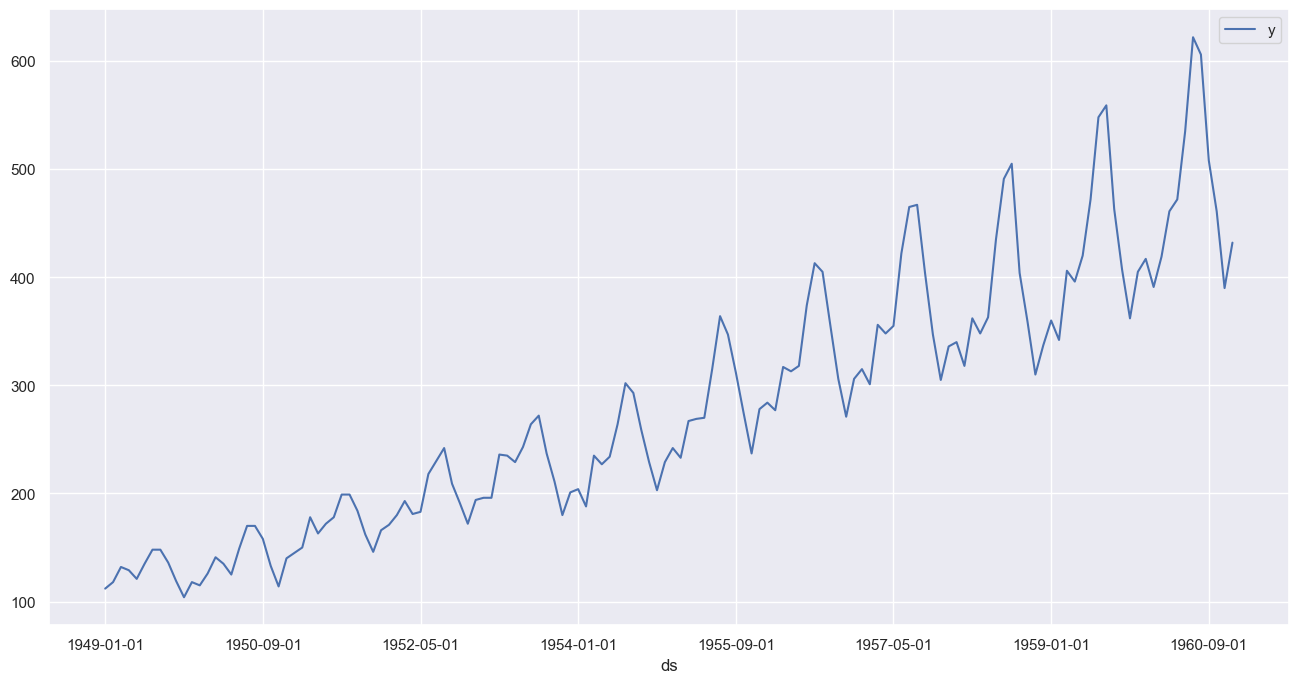

In [ ]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

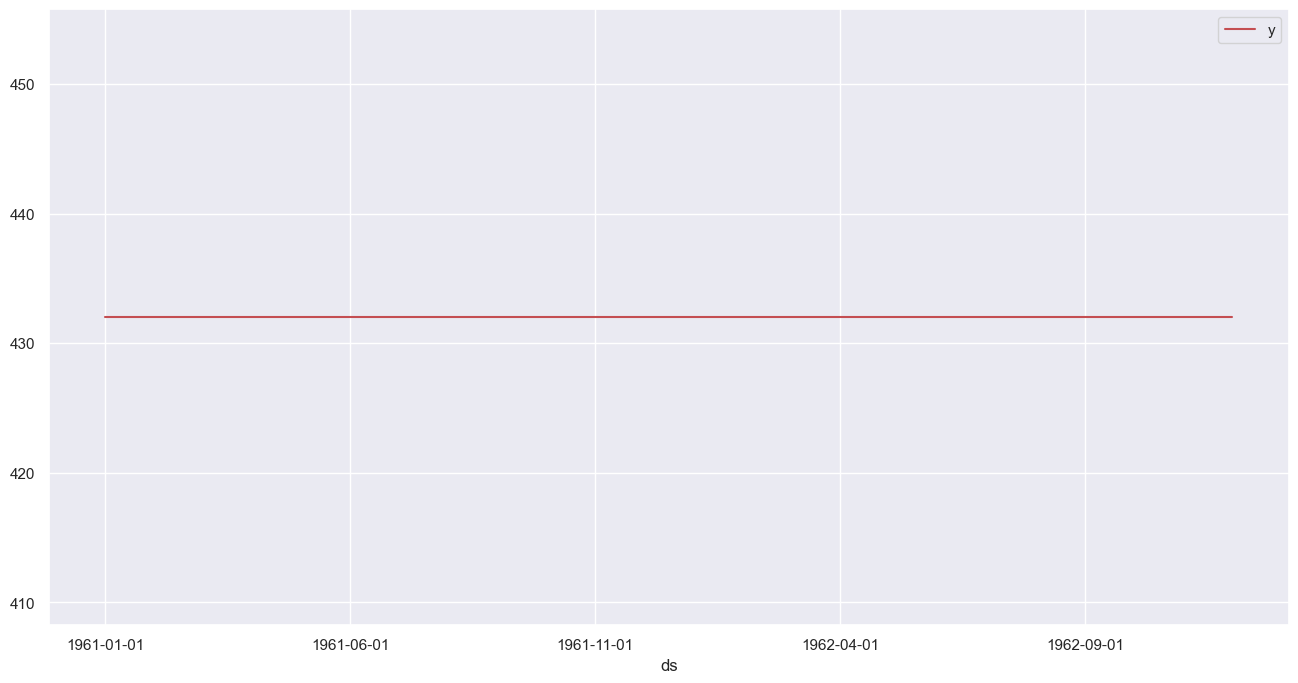

In [ ]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [ ]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [ ]:
df.shape

(168, 3)

In [ ]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [ ]:
df.tail()

,ds,y,color
163,1962-08-01,432.0,r
164,1962-09-01,432.0,r
165,1962-10-01,432.0,r
166,1962-11-01,432.0,r
167,1962-12-01,432.0,r


Plot combined train and forecast sets with the vertical black line as the cut-off

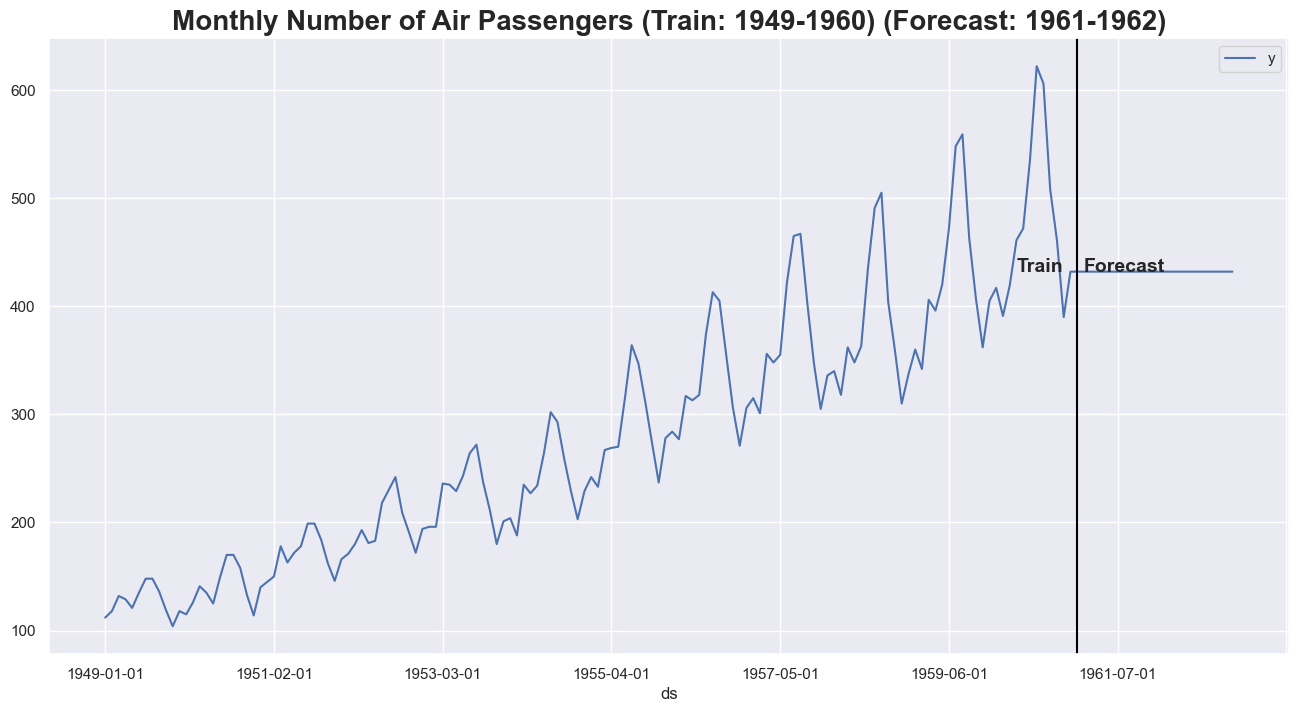

In [ ]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();